# Evaluation

In [8]:
from torch.utils.data import DataLoader # type: ignore
import torch.optim as optim # type: ignore
from torch.optim.lr_scheduler import ReduceLROnPlateau # type: ignore
from torch import nn # type: ignore

from hython.models.cudnnLSTM import CuDNNLSTM
from hython.datasets.datasets import get_dataset
from hython.sampler import *
from hython.normalizer import Normalizer
from hython.trainer import *
from hython.utils import read_from_zarr, missing_location_idx, set_seed, prepare_for_plotting
from hython.evaluator import predict
from hython.trainer import train_val

import matplotlib.pyplot as plt
from hython.viz import map_kge, map_bias, map_pbias, map_pearson, map_rmse, map_at_timesteps, ts_compare, plot_sampler, compute_kge_parallel, ts_plot, map_points

/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
ERROR 1: PROJ: proj_create_from_database: Open of /home/iferrario/.local/miniforge/envs/emulator/share/proj failed


# Settings

In [16]:
## inputs

# wflow model name, i.e. surrogate input file produced by the preprocessing application

file_surr_input =  "/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_input/adg1km_eobs_preprocessed.zarr/"

EXPERIMENT = "test"

dir_wflow_model = "adg1km_eobs"
file_target = "run_default/output.nc"

# input directory 
dir_surr_input = "/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_input"
dir_surr_model = "/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model"
dir_wflow_input = "/mnt/CEPH_PROJECTS/InterTwin/Wflow/models"

## outputs

# directory to save the statistics computed during the normalization
dir_stats_output = "/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_stats"

# === FILTER ==============================================================

# select temporal range
train_temporal_range = ["2016-01-01", "2018-12-31"] 
valid_temporal_range = ["2019-01-01", "2020-12-31"]

# select variable names
dynamic_names = ["precip", "pet", "temp"]
static_names = [ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"]
target_names = [ "vwc","actevap"]

# === MASK ========================================================================================

mask_names = ["mask_missing", "mask_lake"] # names depends on preprocessing application

# == MODEL  ========================================================================================

# DL model hyper parameters
HIDDEN_SIZE = 12
DYNAMIC_INPUT_SIZE = len(dynamic_names)
STATIC_INPUT_SIZE = len(static_names)
OUTPUT_SIZE = len(target_names)
TARGET_WEIGHTS = {t:0.5 for t in target_names}

BATCH = 256

# === METRICS =====================================================================================

metrics = { 
  "vwc": ["rmse", "kge",  "pbias"],
  "actevap": ["rmse", "kge",  "pbias"],
  #"q_river":["rmse", "kge",  "pbias"],
}

In [17]:


file_surr_model = f"{dir_surr_model}/{EXPERIMENT}.pt"

file_wflow_target = f"{dir_wflow_input}/{dir_wflow_model}/{file_target}"


In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_temporal_range = slice(*train_temporal_range)
valid_temporal_range = slice(*valid_temporal_range)

In [19]:
# === READ TRAIN ============================================================= 

Xs = read_from_zarr(url=file_surr_input, group="xs", multi_index="gridcell").xs.sel(
     feat=static_names
 )


# === READ TEST ============================================================= 

Xd_test = (
    read_from_zarr(url=file_surr_input, group="xd", multi_index="gridcell")
    .sel(time=valid_temporal_range)
    .xd.sel(feat=dynamic_names)
)
Y_test = (
    read_from_zarr(url=file_surr_input, group="y", multi_index="gridcell")
    .sel(time=valid_temporal_range)
    .y.sel(feat=target_names)
)

In [20]:
# === MASK ============================================================= 
masks = (
    read_from_zarr(url=file_surr_input, group="mask")
    .mask.sel(mask_layer=mask_names)
    .any(dim="mask_layer")
)


In [21]:
# === NORMALIZE ============================================================= 

normalizer_dynamic = Normalizer(method="standardize", type="spacetime", axis_order="NTC")

normalizer_static = Normalizer(method="standardize", type="space" , axis_order="NTC")

normalizer_target = Normalizer(method="standardize", type="spacetime" , axis_order="NTC")


normalizer_dynamic.read_stats(f"{dir_stats_output}/{EXPERIMENT}_xd.npy")
normalizer_static.read_stats(f"{dir_stats_output}/{EXPERIMENT}_xs.npy")
normalizer_target.read_stats(f"{dir_stats_output}/{EXPERIMENT}_y.npy")


Xd_test = normalizer_dynamic.normalize(Xd_test)
Xs = normalizer_static.normalize(Xs)
Y_test = normalizer_target.normalize(Y_test)

read from /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_stats/test_xd.npy
read from /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_stats/test_xs.npy
read from /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_stats/test_y.npy


In [22]:
# ==== MODEL ============================================================================

model = CuDNNLSTM(
                  hidden_size=HIDDEN_SIZE, 
                  dynamic_input_size=DYNAMIC_INPUT_SIZE,
                  static_input_size=STATIC_INPUT_SIZE, 
                  output_size=OUTPUT_SIZE
)

model.to(device)

# model load precomputed weights 
print(f"loading model {file_surr_model}")
model.load_state_dict(torch.load(file_surr_model))

loading model /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt


<All keys matched successfully>

In [23]:
# === PREDICT =============================================================================

ds_target = xr.open_dataset(file_wflow_target, chunks= {"time":200}).isel(lat=slice(None, None, -1)).sel(layer=1, drop=True)

lat, lon, time = len(masks.lat),len(masks.lon), Xd_test.shape[1]

y_pred = predict(Xd_test.values, Xs.values, model, BATCH, device)


y_pred = normalizer_target.denormalize(y_pred)

Y_test = normalizer_target.denormalize( Y_test)

In [24]:
# === EVALUATE ==============================================================================================

In [25]:
metrics_out = metrics.copy() 

In [26]:
for v in metrics:
    metrics_out[v] = {}
    for m in metrics.get(v):
        metrics_out[v].update({m:""})

In [27]:
mask1d = masks.values.flatten()

vwc
rmse
kge


/home/iferrario/dev/hython/hython/viz.py:133: RuntimeWarning: invalid value encountered in scalar divide
  r = num_r / den_r
/home/iferrario/dev/hython/hython/viz.py:135: RuntimeWarning: divide by zero encountered in scalar divide
  gamma = (np.std(y_pred, axis=0) / m2) / (np.std(y_true, axis=0) / m1)


pbias
actevap
rmse
kge


/home/iferrario/dev/hython/hython/viz.py:133: RuntimeWarning: invalid value encountered in scalar divide
  r = num_r / den_r
/home/iferrario/dev/hython/hython/viz.py:134: RuntimeWarning: divide by zero encountered in scalar divide
  beta = m2 / m1
/home/iferrario/dev/hython/hython/viz.py:135: RuntimeWarning: invalid value encountered in scalar divide
  gamma = (np.std(y_pred, axis=0) / m2) / (np.std(y_true, axis=0) / m1)


pbias


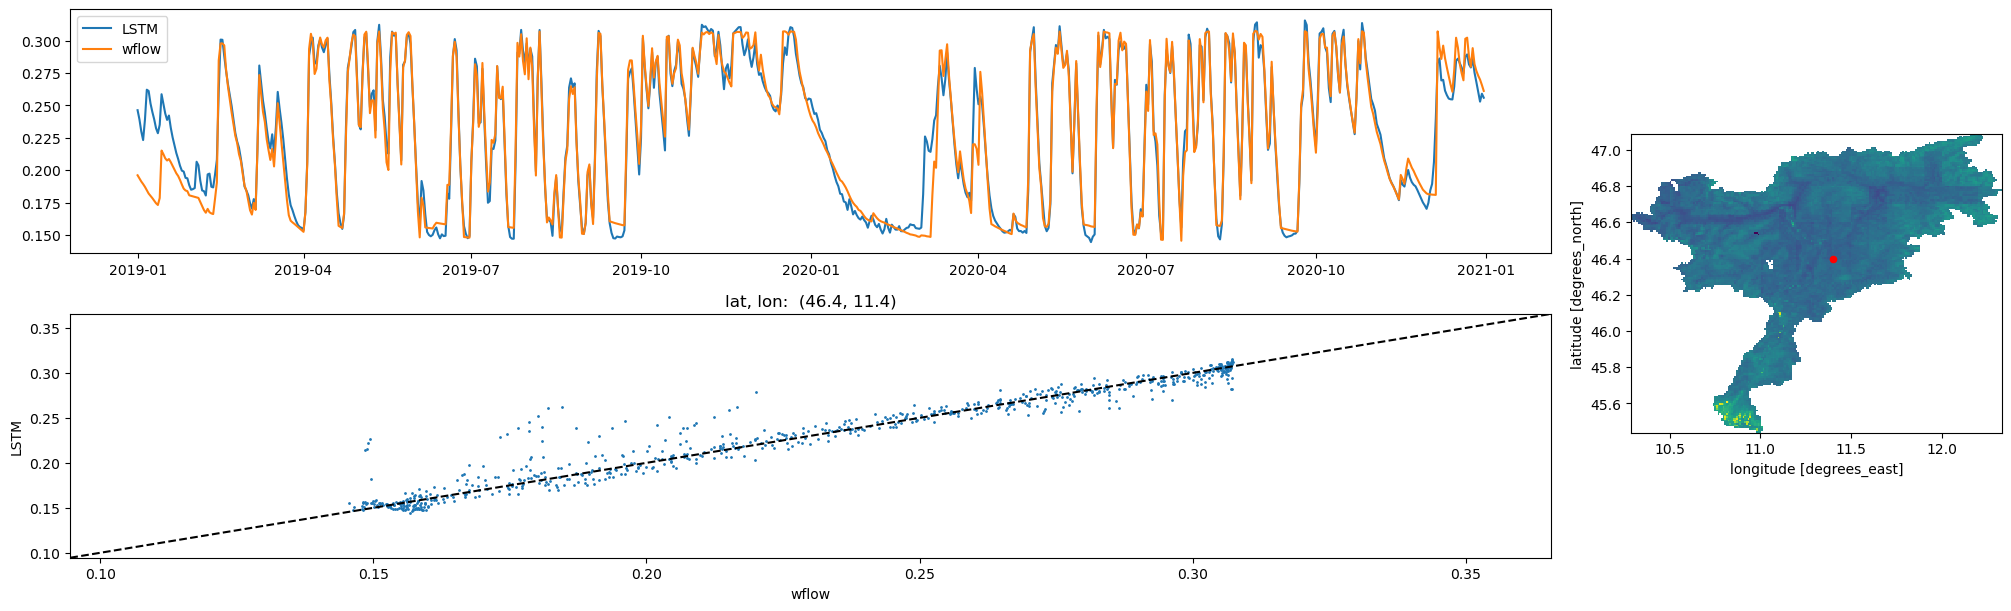

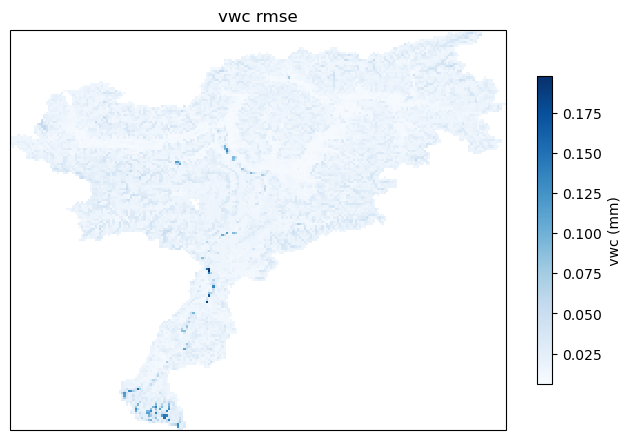

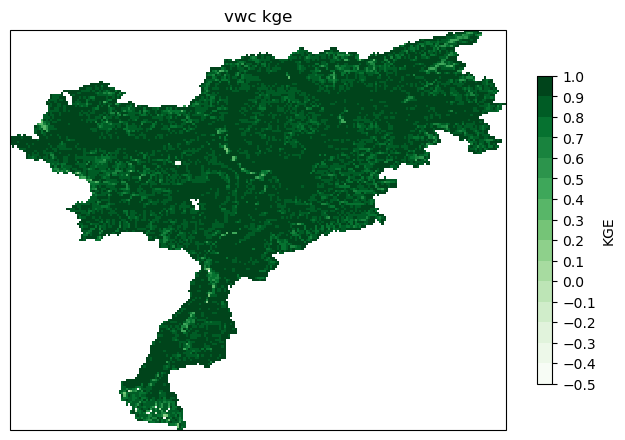

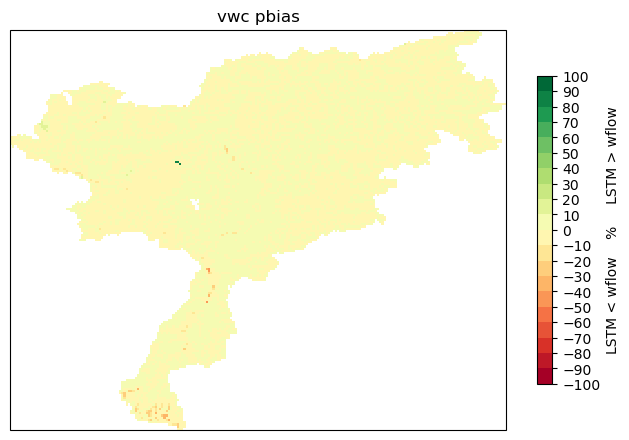

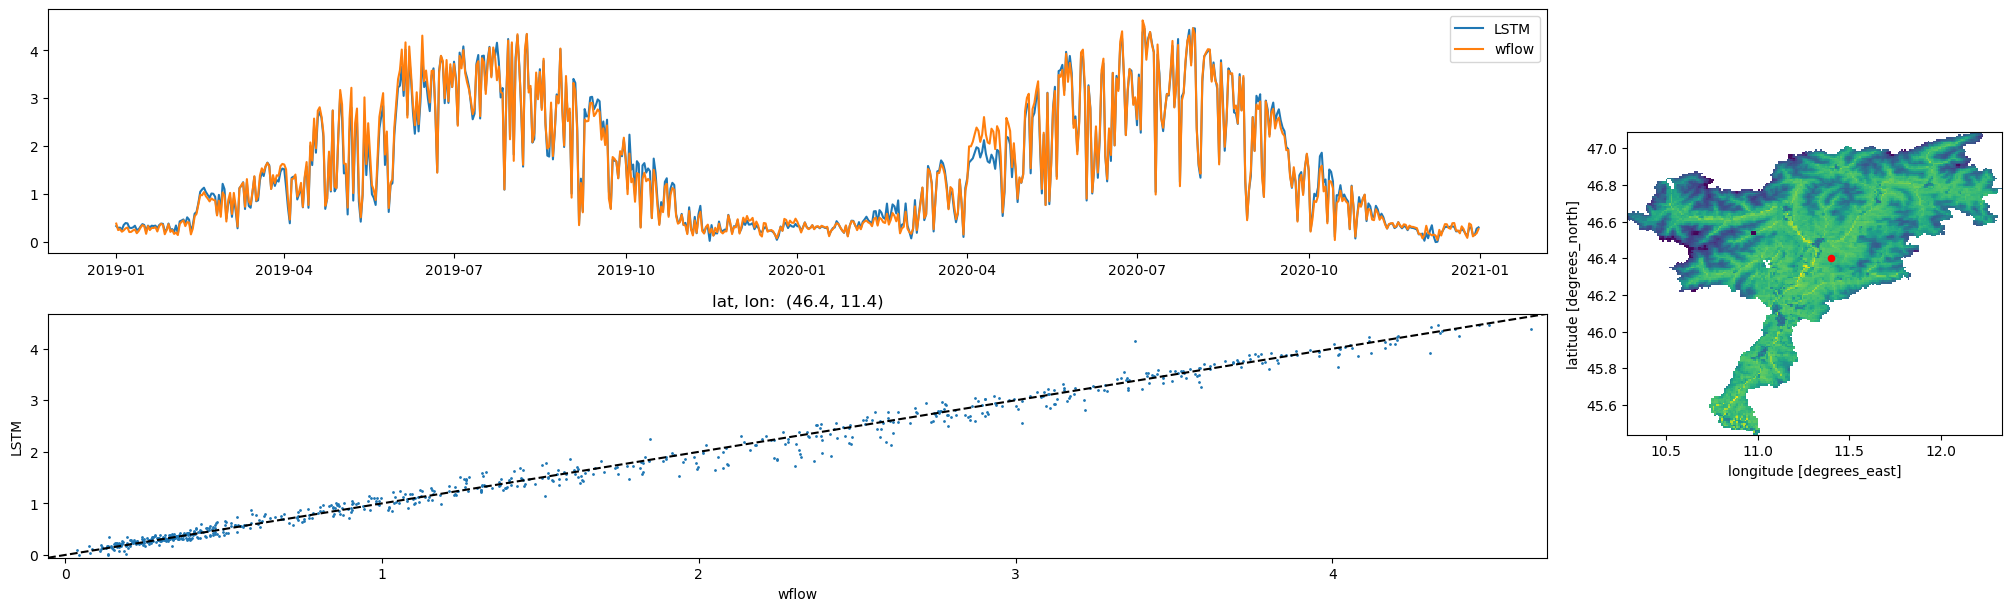

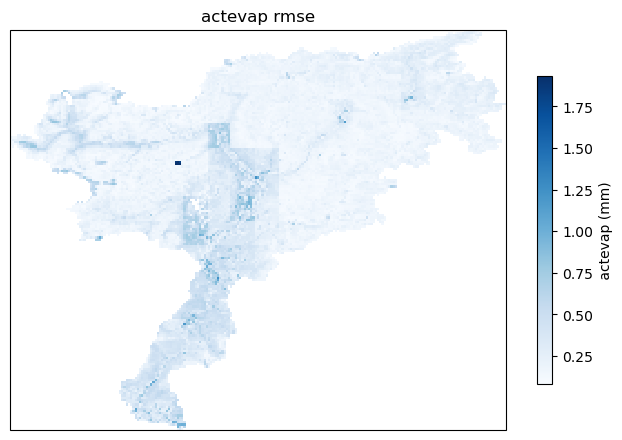

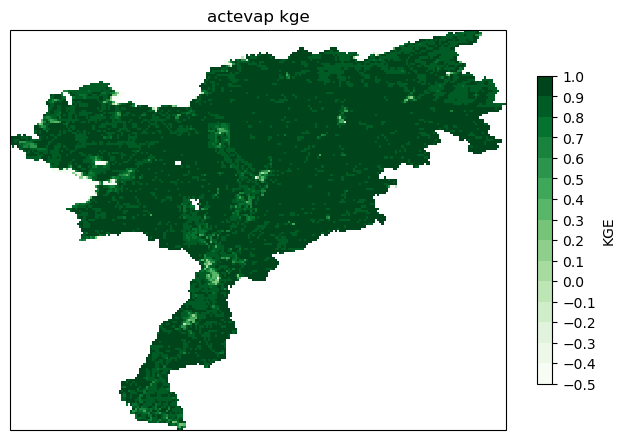

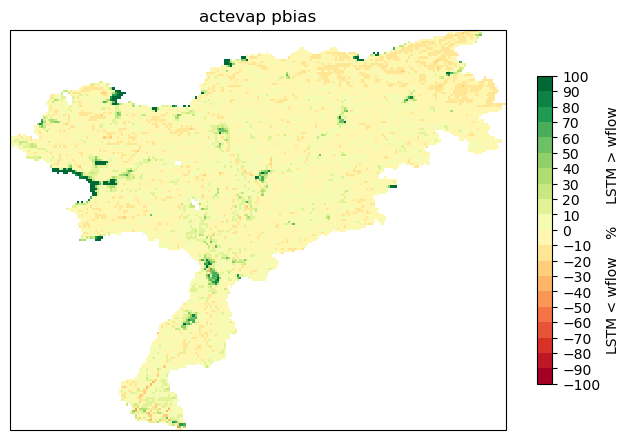

In [28]:


for iv, var in enumerate(target_names):
    print(var)
    metrics_var = metrics.copy().pop(var)

    y_target_plot, y_pred_plot = prepare_for_plotting(y_target= Y_test[:,:,[iv]].values,
                                                y_pred = y_pred[:,:,[iv]], 
                                                shape = (lat, lon, time), 
                                                coords  = ds_target.sel(time=valid_temporal_range).coords)

    y_target_plot= y_target_plot.where(~masks.values[...,None])
    y_pred_plot = y_pred_plot.where(~masks.values[...,None])

    try:
        ts_compare(y_target_plot, y_pred_plot, lat = [46.4], lon = [11.4])    
    except:
        pass
    for metric in metrics_var:
        print(metric)
        if "rmse" in metric:
            fig, ax, rmse = map_rmse(y_target_plot, y_pred_plot, unit = f"{var} (mm)", figsize = (8, 8), return_rmse=True, title=f"{var} {metric}")
            metrics_out[var].update({"rmse":rmse.values.flatten()[~mask1d]})
        elif "kge" in metric:
            fig, ax, kge = map_kge(y_target_plot, y_pred_plot, figsize = (8, 8), return_kge =True, kwargs_imshow={"vmin":-0.5, "vmax":1},
            ticks = np.linspace(-0.5, 1, 16), title=f"{var} {metric}")
            metrics_out[var].update({"kge":kge.values.flatten()[~mask1d]})
        elif "pbias" in metric:
            fig, ax, pbias = map_pbias(y_target_plot, y_pred_plot, figsize = (8, 8), return_pbias=True, kwargs_imshow={"vmin":-100, "vmax":100}, 
            ticks = [l*10 for l in range(-10,11, 1)], title=f"{var} {metric}")
            metrics_out[var].update({"pbias":kge.values.flatten()[~mask1d]})
        else:
            print(f"{metric} not found")
            continue

In [99]:
x = np.linspace(0, 1, np.sum(~mask1d))
y = np.sort(metrics_out["vwc"]["rmse"])

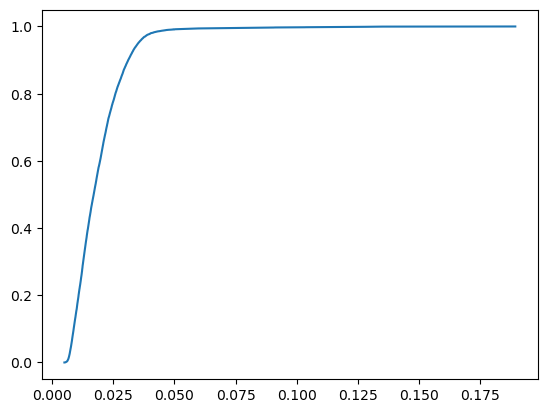

In [100]:
plt.plot(y[y > -1], x[y > -1])

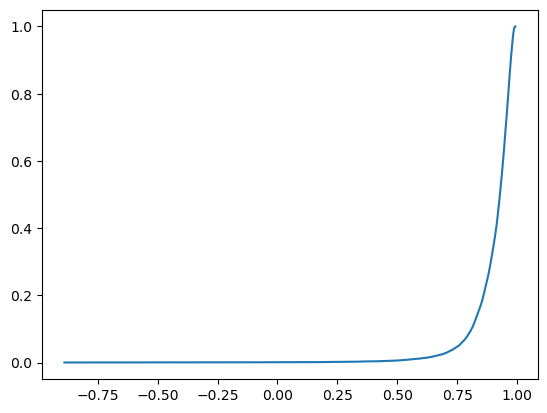

In [67]:
plt.plot(y[y > -1], x[y > -1])

## Compute metrics 

## Compare experiments